<h1>Chapter 3: Classification</h3>
<h2>3.1 Introduction</h3>
<p><b>Classification</b> is a supervised ML method where the model tries to predict the correct label of a given input data. In classification, the model is fully trained using the training data, and then it is evaluated on test data before being used to perform prediction on new unseen data. </p>

<h2>3.2 MNIST</h2>
<p>We'll be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. </P>

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

X.shape, y.shape

((70000, 784), (70000,))

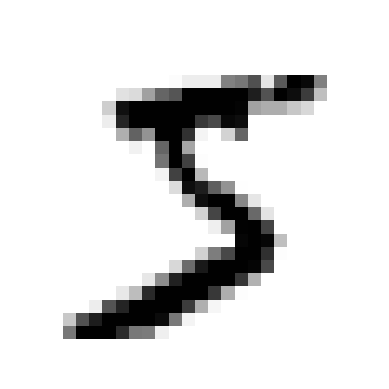

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Convert DataFrame to NumPy array if it isn't already
# Assuming `X` is a DataFrame and each row is an image in flattened form
X_np = X.to_numpy()  # Convert DataFrame to NumPy array

# Select the first image from the dataset
some_digit = X_np[0]  # Select the first row/image

# Reshape the selected image to 28x28 pixels
some_digit_image = some_digit.reshape(28, 28)

# Plot the image
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


In [13]:
y[0]

'5'

In [14]:
import numpy as np

y = y.astype(np.uint8)

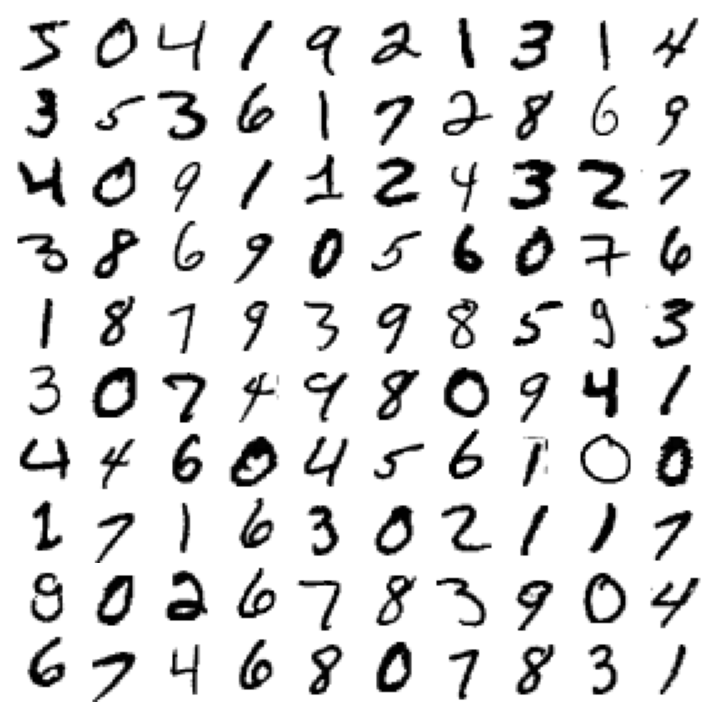

In [29]:
# Function to plot a single digit
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# Create a figure to plot 100 digits
plt.figure(figsize=(9, 9))

# Plot the first 100 digits
for idx, image_data in enumerate(X_np[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)

# Adjust subplot spacing
plt.subplots_adjust(wspace=0, hspace=0)

# Show the plot
plt.show()


<p>The MNIST dataset is already split up into a training set (the first 60,000 images) and a test set (the last 10,000 images).</p>

<p>The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar. Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. </p>

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

<h2>3.3 Training a Binary Classifier</h2>
<p>First, we will only attempt to identify one digit, the number 5. This will be an example of a binary classifier.</p>

In [18]:
y_train_5 = (y_train == 5)
x_test_5 = (y_test == 5)

<p>Next, we will pick a classifier and train it. A good place to start is with a <em>Stochastic Gradient Descent</em> classifier. </p>

In [19]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [20]:
sgd_clf.predict([some_digit])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

<h3>3.3.1 Performance Measures</h3>
<h4>3.3.1.1 Meausring Accuracy Using Cross-Validation</h4>
<p>Let's use the cross_val_score() function to evaluate over SGDClassifier model, using K-fold cross-validation with three folds. </p>

<p>K-fold cross-valiation means splitting the training set into K folds, then making predictions and evaluating them on each fold using a model trained on the remaining folds:</p>

In [22]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

<p>Here, we have on average over 95% accuracy on all cross-validation folds. </p>

<p>Let's look at a classifier which just classifies every single image in the "not-5" class:</p>

In [25]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)
    
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

<p>This apparaently has over 90% asccuracy. But, this is simply because only about 90% of the images are 5s, so if you always guess that an image is not 5, you will be right about 90% of the time.</p>

<p>This demonstrates why accuracy is not the preferred performance measure for classifiers, especially when you're dealing with skewed datasets. </p>

<h4>3.3.1.2 Confusion Matrix</h4>
<p>The general idea of a Confusion Matrix is to count the number of times instances of class A are classified as class B. To compute the confusion matrix, you first need to have a set of predictions os that they can be compared to the targets. </p>

In [26]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

<p>Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row considers non-5 images (negative class), with 53k correctly classified, and 687 incorrectly classified. The second row represents 5 images, with 1k and 3k correctly and incorrectly classified. </p>

<p>The confusion matrix gives you a lot of info, but sometimes we may prefer more concise metrics. An interesting one ot look at is the accuracy of a positive prediction, called the <em>precision</em> of a classifier. </p>

<p>Precision is commonly used along with anotehr metric named <em>recall</em>, also called <em>sensitivity</em>,

<h4>3.3.1.3 Precision and Recall</h4>

In [28]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

<p>Now, our 5-detector doesn't look so accurate after all. When it claims to represent a 5, it is correctly only 83% of the time, and it only detects 65% of the 5s. </p>

<p>It is often convenient to combine precision and recall into a single metric called the $F_{1}$ score, in particular if you need a simple way to compare two classifiers. This is the harmonic mean of the precision and recall.</p>

In [30]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

<h5>3.3.1.3.1 Precision/Recall Trade-off</h5>
<p>Increasing precision reduces recall, and vice-versa. </p>

<p>To understand this trade-off, let us look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise, it assigns it to the negative class. </p>

<p>Some decision threshold is defined, which Scikit-Learn does not let you set directly, but it gives you access to the decision score that it uses to make predictions. The classifier calculates the decision score for each instance, and if the decision score is equal to or higher than the threshold value, then it predicts a positive class. If it is less, then it belongs to the negative class. </p>

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [35]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [36]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

<p>We can then see that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8000.</p>

<p>How do you decide which threshold to use? First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:</p>

In [37]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

<p>With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds:</p>

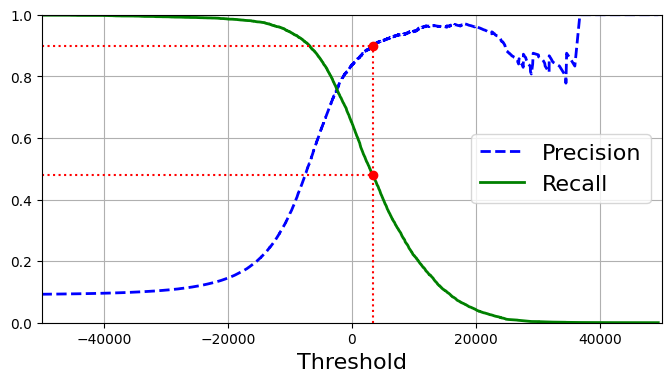

In [40]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1])             

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                         
plt.show()

<p>Another way to select a good precision/recall trade-off is to plot precision directly against recall, like so:</p>

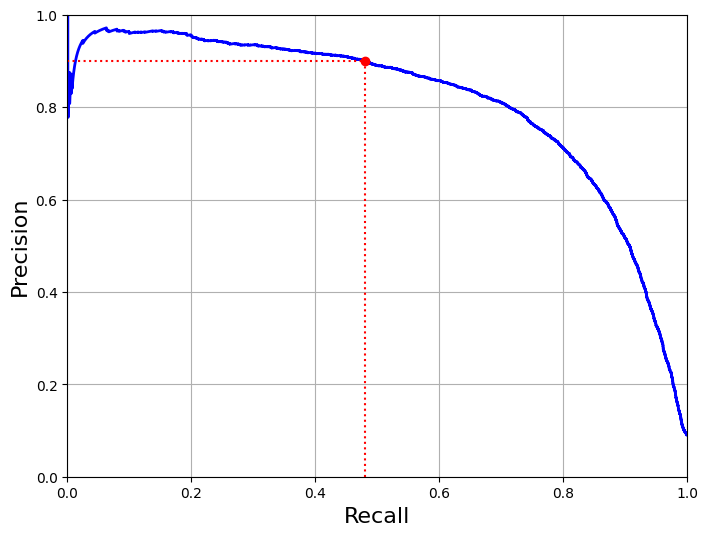

In [41]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()


<p>We can see that the precision really starts to fall sharply around 80% recall. You'd probably want to select a precision/recall trade-off just before that drop - for example, at around 60% recall. </p>

<p>Suppose you want to aim for 90% precision. We first have to search for the lowest threshold that gives you 90% precision.</p>

In [42]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9000345901072293, 0.4799852425751706)

<p>We can see that we can easily create a classifier with virtually any precision you want, but a high-precision classifier is not very useful if the recall is too low. </p>

<h4>3.3.1.4 The ROC Curve</h4>
<p>The receiver operator characteristic (ROC) curve is another common tool used in with binary classifiers. It plots the tru positive rate (recall) against the false positive rate (FPR). The FPR is the ratio of negative isntances that are incorrectly classified as positives, which is equal to (1-true negative rate, aka specificity). Hence, the ROC curve plots sensitivity (recall) against 1-specificity. </p>

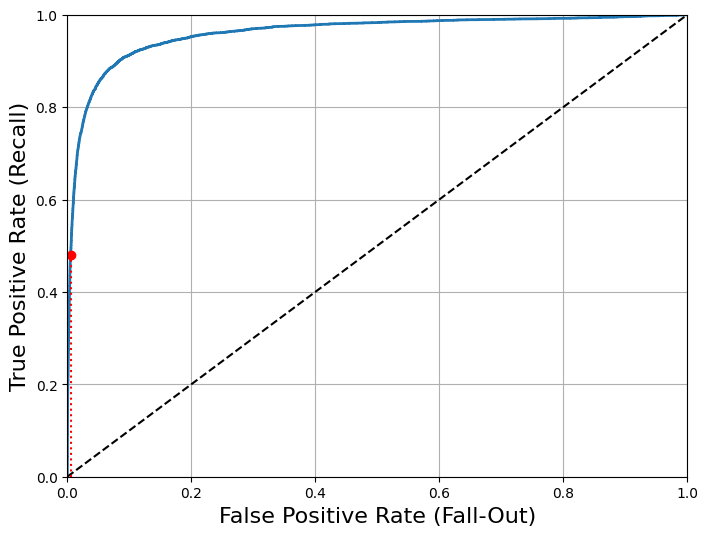

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                   
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                   
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:") 
plt.plot([fpr_90], [recall_90_precision], "ro")                                             
plt.show()

<p>Once again there is a trade off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. </p>

<p>The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible. </p>

<p>One wya to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5 </p>

In [45]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

<p>We will now train a RandomForestClassifier, and compare its ROC curve and ROC AUC score with those of the SGDClassifier. </p>

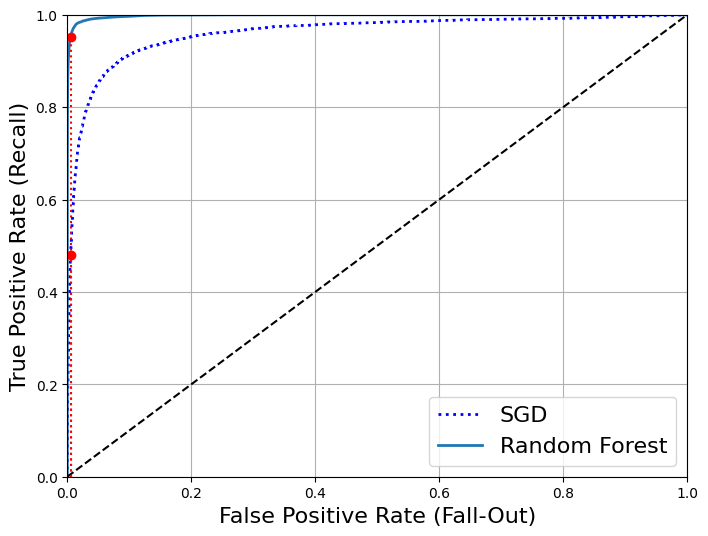

In [46]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, "b:", linewidth = 2, label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize = 16)
plt.show()

In [47]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [49]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)

precision_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred_forest)

(0.9905083315756169, 0.8662608374838591)

<p>The ROC curve looks much better for the RandomForestClassifier, the ROC AUC score is better, and the precision and recall are better. </p>

<h2>3.4 Multiclass Classification</h4>